# Example running pre-trained models using example data

Import modules

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import waveStats

## Read in a prepare example datasets

In [2]:
hindcast = xr.open_dataset("../data/example_hindcast_spec.nc")
observations = xr.open_dataset("../data/example_observations_spec.nc")

## Pre-process data

In [3]:
features = hindcast.efth.sortby('dir').sortby('freq').values
features = np.reshape(features, (features.shape[0], -1))

#add time based features
# Extract time-based features
time_index = hindcast.time.to_index()

# Convert to DataFrame for easy manipulation
time_df = pd.DataFrame(index=time_index)
weeks = time_df.index.year
months = time_df.index.month
days = time_df.index.day
#encode day, year, month
time_df['day'] = (days - 1) / 30.0  # Approximation
time_df['month'] = (months - 1) / 11.0
time_df['year'] = (weeks - 1) / 52.0

#encode hours as sin and cos
hours = time_df.index.hour
time_df['hour_sin'] = np.sin(2 * np.pi * hours / 23.0)
time_df['hour_cos'] = np.cos(2 * np.pi * hours / 23.0)

# Convert time-based features to a numpy array
time_features = time_df.values

labels = observations.efth.sortby('dir').sortby('freq').values
desired_shape = (labels.shape[0], labels.shape[1], labels.shape[2])
labels = np.reshape(labels, (labels.shape[0], -1))

In [4]:
print("feature shape: ", features.shape)
print("label_shape: ", labels.shape)

feature shape:  (529, 696)
label_shape:  (529, 4176)


In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [6]:
# Scaling function
def scale_data(X_train, y_train,):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
        
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    return X_train_scaled, y_train_scaled, scaler_X, scaler_y

# Scaling the data
X_scaled, y_scaled, scaler_X, scaler_y = scale_data(features, labels)

In [7]:
def create_sequences_ignore_nans(features, labels, seq_length):
    X_sequences = []
    y_sequences = []
    for i in range(len(features) - seq_length):
        X_sequences.append(features[i:i+seq_length])
        y_sequences.append(labels[i+seq_length])
    return np.array(X_sequences), np.array(y_sequences)


In [8]:
# Define the sequence length (number of time steps to consider as input)
seq_length = 14

# Function to create sequences, skipping over gaps
def create_sequences(features, labels, seq_length, time_index, gap_threshold='1h'):
    X_sequences = []
    y_sequences = []
    pred_times = []  # List to store timestamps for predictions

    gaps = np.diff(time_index) > pd.Timedelta(gap_threshold)

    # Mark sequences that should be skipped due to gaps
    invalid_start_indices = np.where(gaps)[0] + 1 - seq_length
    invalid_start_indices = invalid_start_indices[invalid_start_indices >= 0]

    for i in range(len(features) - seq_length):
        if np.any((invalid_start_indices <= i) & (invalid_start_indices > i - seq_length)):
            continue  # Skip sequence that spans a gap
        if np.any(np.isnan(features[i:i+seq_length])):
            continue
        if np.any(np.isnan(labels[i+seq_length])):
            continue
        
        X_sequences.append(features[i:i+seq_length])
        y_sequences.append(labels[i+seq_length])
        pred_times.append(time_index[i+seq_length])  # Store the timestamp for prediction

    return np.array(X_sequences), np.array(y_sequences), np.array(pred_times)

X_sequences, y_sequences, pred_times = create_sequences(X_scaled, y_scaled, seq_length, hindcast.time.to_index())

In [9]:
print("X_sequences shape:", X_sequences.shape)
print("y_sequences shape:", y_sequences.shape)
print("Prediction timestamps shape:", pred_times.shape)

X_sequences shape: (515, 14, 696)
y_sequences shape: (515, 4176)
Prediction timestamps shape: (515,)


Prepare for pytorch

In [10]:
import torch

In [11]:
X_sequences = torch.tensor(X_sequences, dtype=torch.float32)
y_sequences = torch.tensor(y_sequences, dtype=torch.float32)

# Load pre-trained models

In [12]:
from torch.utils.data import DataLoader, TensorDataset
import models

In [13]:
# Function to load a pre-trained GRU model
def load_biltsmgru_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=0.2, device= 'cpu'):
    model = models.CNN_LSTM_BiGRU(input_size, hidden_size, num_layers, output_size, dropout=dropout)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)  # Move model to the specified device
    return model

In [14]:

input_size = X_sequences.shape[2]  # Number of features
hidden_size = 164
num_layers = 3
output_size = y_sequences.shape[1]  # Number of labels
dropout = 0.5
patience = 7

model_path = '../models/best_cnn_lstm_bigru_model_v2.pth'

cnn_lstm_bigru = load_biltsmgru_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=dropout, device="cpu")

In [15]:
# Function to load a pre-trained GRU model
def load_cnnltsm_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=0.2, device= 'cpu'):
    model = models.CNNLSTMModel(input_size, hidden_size, num_layers, output_size, dropout=dropout)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)  # Move model to the specified device
    model.eval()
    return model

In [16]:
input_size = X_sequences.shape  # Number of features
hidden_size = 164
num_layers = 4
output_size = y_sequences.shape[1]  # Number of labels
dropout = 0.4
patience = 7 

model_path = '../models/best_cnn_lstm_model_v2.pth'

cnnltsm_model = load_cnnltsm_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=dropout, device="cpu")

In [17]:
input_size = X_sequences.shape[2]  # Number of features
hidden_size = 164
num_layers = 4
output_size = y_sequences.shape[1]  # Number of labels
dropout = 0.4
patience = 7 

# Function to load a pre-trained GRU model
def load_gru_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=0.2, device= 'cpu'):
    model = models.GRUModel(input_size, hidden_size, num_layers, output_size, dropout=dropout)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)  # Move model to the specified device
    model.eval()
    return model

model_path = '../models/best_gru_model_v2.pth'

gru_model = load_gru_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=dropout, device="cpu")

In [18]:
# Function to load a pre-trained model
def load_lstm_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=0.2, device= 'cpu'):
    model = models.LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=dropout)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)  # Move model to the specified device
    model.eval()
    return model

In [19]:
input_size = X_sequences.shape[2]  # Number of features
hidden_size = 164
num_layers = 2  # Reduced number of layers
output_size = y_sequences.shape[1]  # Number of labels
dropout = 0.4
patience = 5 
model_path = '../models/best_lstm_model_v2.pth'

ltsm_model = load_lstm_model(model_path, input_size, hidden_size, num_layers, output_size, dropout=dropout, device="cpu")

## Make prediction

In [20]:
# Make predictions for the entire independent dataset
cnn_lstm_bigru.eval()
all_predictions = []

with torch.no_grad():
    for i in range(X_sequences.shape[0]):
        future_inputs = X_sequences[i].unsqueeze(0)  # Get the i-th sequence
        future_predictions = cnn_lstm_bigru(future_inputs)
        all_predictions.append(future_predictions.cpu().numpy().squeeze())

# Convert predictions to numpy array
all_predictions = np.array(all_predictions)

# Inverse transform the predictions
all_predictions = scaler_y.inverse_transform(all_predictions)

# Reshape predictions to match the original dimensions (time, freq, dir)
predicted_efth = all_predictions.reshape((len(all_predictions),) + desired_shape[1:])

# Create xarray Dataset
predicted_dataset_cnnltsmbigru = xr.Dataset(
    {"efth": (("time", "freq", "dir"), predicted_efth)},
    coords={
        "time": pred_times,  # Adjust time range for predictions
        "freq": observations.freq.values,
        "dir": observations.dir.values,
    },
)

predicted_dataset_cnnltsmbigru['efth'].values = np.where(predicted_dataset_cnnltsmbigru.efth.values < 0.0001, 0, predicted_dataset_cnnltsmbigru.efth.values )

In [21]:
# Make predictions for the entire independent dataset
cnnltsm_model.eval()
all_predictions = []

with torch.no_grad():
    for i in range(X_sequences.shape[0]):
        future_inputs = X_sequences[i].unsqueeze(0)  # Get the i-th sequence
        future_predictions = cnnltsm_model(future_inputs)
        all_predictions.append(future_predictions.cpu().numpy().squeeze())

# Convert predictions to numpy array
all_predictions = np.array(all_predictions)

# Inverse transform the predictions
all_predictions = scaler_y.inverse_transform(all_predictions)

# Reshape predictions to match the original dimensions (time, freq, dir)
predicted_efth = all_predictions.reshape((len(all_predictions),) + desired_shape[1:])

# Create xarray Dataset
predicted_dataset_cnnltsm = xr.Dataset(
    {"efth": (("time", "freq", "dir"), predicted_efth)},
    coords={
        "time": pred_times,  # Adjust time range for predictions
        "freq": observations.freq.values,
        "dir": observations.dir.values,
    },
)

predicted_dataset_cnnltsm['efth'].values = np.where(predicted_dataset_cnnltsm.efth.values < 0.0001, 0, predicted_dataset_cnnltsm.efth.values )

In [22]:
# Make predictions for the entire independent dataset
gru_model.eval()
all_predictions = []

with torch.no_grad():
    for i in range(X_sequences.shape[0]):
        future_inputs = X_sequences[i].unsqueeze(0)  # Get the i-th sequence
        future_predictions = gru_model(future_inputs)
        all_predictions.append(future_predictions.cpu().numpy().squeeze())

# Convert predictions to numpy array
all_predictions = np.array(all_predictions)

# Inverse transform the predictions
all_predictions = scaler_y.inverse_transform(all_predictions)

# Reshape predictions to match the original dimensions (time, freq, dir)
predicted_efth = all_predictions.reshape((len(all_predictions),) + desired_shape[1:])

# Create xarray Dataset
predicted_dataset_gru = xr.Dataset(
    {"efth": (("time", "freq", "dir"), predicted_efth)},
    coords={
        "time": pred_times,  # Adjust time range for predictions
        "freq": observations.freq.values,
        "dir": observations.dir.values,
    },
)

predicted_dataset_gru['efth'].values = np.where(predicted_dataset_gru.efth.values < 0.0001, 0, predicted_dataset_gru.efth.values )

In [23]:
# Make predictions for the entire independent dataset
ltsm_model.eval()
all_predictions = []

with torch.no_grad():
    for i in range(X_sequences.shape[0]):
        future_inputs = X_sequences[i].unsqueeze(0)  # Get the i-th sequence
        future_predictions = ltsm_model(future_inputs)
        all_predictions.append(future_predictions.cpu().numpy().squeeze())

# Convert predictions to numpy array
all_predictions = np.array(all_predictions)

# Inverse transform the predictions
all_predictions = scaler_y.inverse_transform(all_predictions)

# Reshape predictions to match the original dimensions (time, freq, dir)
predicted_efth = all_predictions.reshape((len(all_predictions),) + desired_shape[1:])

# Create xarray Dataset
predicted_dataset_lstm = xr.Dataset(
    {"efth": (("time", "freq", "dir"), predicted_efth)},
    coords={
        "time": pred_times,  # Adjust time range for predictions
        "freq": observations.freq.values,
        "dir": observations.dir.values,
    },
)

predicted_dataset_lstm['efth'].values = np.where(predicted_dataset_lstm.efth.values < 0.0001, 0, predicted_dataset_lstm.efth.values )

## Plot the prediction

In [24]:
def calculate_wave_parameters_for_all_timesteps(dataset):
    wave_params_list = []
    times = []

    for time in dataset.time:
        efth_slice = dataset.sel(time=time).efth
        wave_params = waveStats.calculate_wave_parameters(efth_slice)  # Adjust this line based on your function's requirements
        wave_params_list.append(wave_params)
        times.append(time.values)

    wave_params_df = pd.concat(wave_params_list)
    return wave_params_df

In [25]:
predicted_dataset_cnnltsmbigru_params = calculate_wave_parameters_for_all_timesteps(predicted_dataset_cnnltsmbigru)
predicted_dataset_cnn_ltsm_params = calculate_wave_parameters_for_all_timesteps(predicted_dataset_cnnltsm)
predicted_dataset_gru_params = calculate_wave_parameters_for_all_timesteps(predicted_dataset_gru)
predicted_dataset_lstm_params = calculate_wave_parameters_for_all_timesteps(predicted_dataset_lstm)

compare with observed and offshore for the same time

In [26]:
obs_wave_params = calculate_wave_parameters_for_all_timesteps(observations.sel(time=predicted_dataset_cnn_ltsm_params.index))
hindcast_wave_params = calculate_wave_parameters_for_all_timesteps(hindcast.sel(time=predicted_dataset_cnn_ltsm_params.index))

## Plot the datasets for comparison

Here we plot the Hm0 for each dataset for comparison.

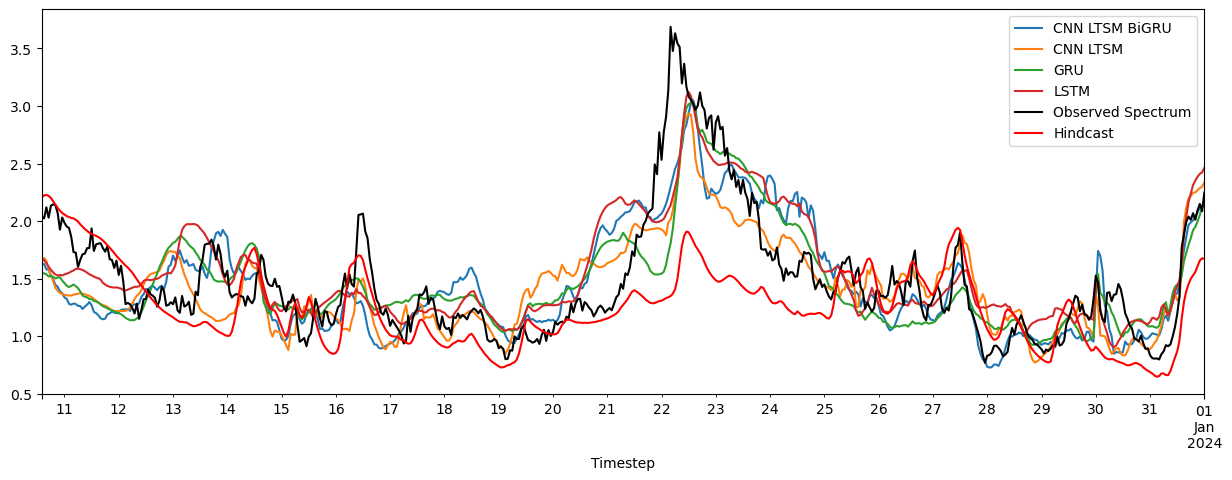

In [29]:
fig, ax = plt.subplots(figsize = (15, 5))
predicted_dataset_cnnltsmbigru_params.Hm0.plot(label = "CNN LTSM BiGRU", ax = ax)
predicted_dataset_cnn_ltsm_params.Hm0.plot(label = "CNN LTSM", ax = ax)
predicted_dataset_gru_params.Hm0.plot(label = "GRU", ax = ax)
predicted_dataset_lstm_params.Hm0.plot(label = "LSTM", ax = ax)
obs_wave_params.Hm0.plot(label = "Observed Spectrum", ax = ax, color = 'black')
hindcast_wave_params.Hm0.plot(label = "Hindcast", ax = ax, color = 'red')
ax.set_ylabel = "Hm0"
plt.legend()
plt.show()